# Assignment 2

## French to English Translation Using Sequence-to-Sequence RNNs with Attention

#### What is NMT (Nueral Machine Translation)?  and how it is done using a sequence-to-sequence RNN with attention?


`Neural Machine Translation (NMT)` is an approach that employs sequence-to-sequence models and neural networks to translate text between languages. The NMT system consists of two crucial components: an encoder and a decoder. The encoder processes the input sentence and converts it into a fixed-length vector representation known as the context vector. Subsequently, the decoder utilizes this vector as input and generates the translated sentence in the target language. `Recurrent Neural Networks (RNNs)` are commonly used as the underlying architecture of the neural network, as they excel in processing sequential data and capturing the contextual dependencies between words. 

To handle sequential data effectively, two types of `RNNs`, namely` Long Short-Term Memory (LSTM)` and `Gated Recurrent Unit (GRU)`, are often employed to mitigate issues such as vanishing and exploding gradients. To enhance translation performance, attention mechanisms are integrated with `RNNs`. Instead of relying on a single fixed context vector in the final layer of the encoding process, the attention model dynamically develops a context vector for each time step, resulting in multiple hidden layers. The context vector is computed by taking a weighted sum of the encoder's hidden states, with the attention weights serving as the weights for the sum.

It became more clear to me reading, editing, and executing the code:
   
    Encoder:
    In the sequence-to-sequence model with attention, the prepared data is fed into the Encoder. The data is then embedded and passed to the RNN (GRU or LSTM). The Encoder returns the output and the final hidden state. If the attention architecture is used, each hidden state is passed into the Encoder as part of the input, along with the final hidden state.

    Decoder:
    In each time step, the current input sequence being predicted, along with the previous hidden state, is used to predict the next word/value in the sequence when fed into the RNN (GRU or LSTM). When attention is used, the Decoder utilizes the encoder hidden states. It multiplies them with the values from the linearly transformed input and the previous hidden state. Softmax is then applied to determine the importance of each feature, providing weights. This allows us to identify the features that receive "attention," which is highly intuitive.
    
    Attention Mechanism (ChatGPT):
    The attention mechanism in the sequence-to-sequence model enables the decoder to selectively focus on various sections of the input sequence instead of relying solely on a single context vector. It achieves this by calculating attention weights at each time step, determining the relative importance of each encoder hidden state with respect to the current state of the decoder. These attention weights serve as the weighting factors for a weighted sum of the encoder hidden states. The resulting context vector is then obtained as the sum of the encoder hidden states, weighted by the attention weights.

Attention improves the translation quality and can handle longer translation however the downside is the computational complexity and resource requirements along with huge dependency on the training data we are using for the translations.

`NMT` can also be used in text summarization, code generation in programming, handwriting recognition and a lot more use cases.

#### What is the dataset being used?

The dataset 'eng-fra.txt' contains pairs of English to French translation that is delimted by \t (tab). 

It contains 135,482 pairs however in the this exercise it will only be sampled to a few thousand lines to speed up the training

In [1]:
import pandas as pd
lines = open('data/eng-fra.txt', encoding='utf-8').read().strip().split('\n')
print(f'Total pair: {len(lines)}')
lines[10:20]

Total pair: 135842


['Wait!\tAttends !',
 'Wait!\tAttendez !',
 'I see.\tJe comprends.',
 "I try.\tJ'essaye.",
 "I won!\tJ'ai gagné !",
 "I won!\tJe l'ai emporté !",
 'Oh no!\tOh non !',
 'Attack!\tAttaque !',
 'Attack!\tAttaquez !',
 'Cheers!\tSanté !']

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
SOS_token = 0
EOS_token = 1
# SOS_token and EOS_token are special tokens representing the start and end of a sentence respectively.

"""
   Class Lang is responsible for adding new words into a dictionary and 
   increments it count if a similar one exists. It initalizates with the name
   of the language along with the indexes for the start and end of string
   token.
"""

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}  # A dictionary to map words to their corresponding indices
        self.word2count = {}  # A dictionary to track the count of each word
        self.index2word = {0: "SOS", 1: "EOS"}  # A dictionary to map indices back to their corresponding words
        self.n_words = 2  # Initialize the count of words with SOS and EOS tokens (2 initially)

    def addSentence(self, sentence):
        for word in sentence.split(' '):  # Split the sentence into words
            self.addWord(word)  # Call the addWord method to add each word to the language

    def addWord(self, word):
        if word not in self.word2index:  # If the word is not already present in the dictionary
            self.word2index[word] = self.n_words  # Assign a unique index to the word
            self.word2count[word] = 1  # Set the word count to 1
            self.index2word[self.n_words] = word  # Map the index to the word
            self.n_words += 1  # Increment the count of words
        else:
            self.word2count[word] += 1  # If the word already exists, increment its count



#### What are the preprocessing steps being done in preparation for training the model?

1. The code loads the `eng-fra.txt` file and processes it to create separate dictionaries for the source (English) and target (French) languages. The reverse flag is set to True because the translation is from English to French. 

2. The input string is normalized by converting any `Unicode` characters to their `ASCII` equivalents, converting all characters to lowercase, and removing leading and trailing whitespaces. This step helps ensure consistent handling of text data.


3. Punctuation marks `(. ! ?)` are surrounded by spaces to separate them from the surrounding words. Additionally, any non-alphabetic characters (excluding punctuation marks) are replaced with spaces. This step ensures that the text consists only of valid tokens and facilitates further processing.


4. The code limits the sentences to a maximum of 10 words, including punctuation. It also filters out sentences that do not start with specific English prefixes (eng_prefixes). This step helps control the length and content of the sentences used in the translation process.


5. The pair sentences are built using the Lang class, which represents the input and output languages. This class is responsible for handling the vocabulary and word-to-index mappings for each language.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 10  # Maximum allowed length for sentences

eng_prefixes = (
    "i am ", "i m ",  # Common English sentence prefixes
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    """
        Check if both sentences in the pair have lengths less than MAX_LENGTH
        and if the target sentence starts with one of the specified English prefixes
        
        p - string value of the translation
    """
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    # Filter out pairs that do not meet the criteria specified by filterPair
    return [pair for pair in pairs if filterPair(pair)]


In [7]:
def prepareData(lang1, lang2, reverse=False):
    # Read language pairs and create language instances
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    # Filter pairs based on length and prefixes
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))

    print("Counting words...")
    # Add sentences to language instances for vocabulary construction
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    # Print the name and word count of each language
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    # Return the prepared language instances and sentence pairs
    return input_lang, output_lang, pairs


# Prepare data for English-to-French translation with reversed language pairs
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

# Print a random pair from the prepared data
print(random.choice(pairs))


Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je vais t acheter une montre .', 'i m going to buy you a watch .']


### Encoder - Decoder

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
            Initializes the encoder class for GRU and accepts integer value
            for the input_size and hidden_size
        """
        
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer to convert input tokens to dense vectors
        self.embedding = nn.Embedding(input_size, hidden_size)

        # GRU layer for processing sequential input
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        """
            Function is the forward pass of the model where it creates
            the embedding layer and goes into the RNN (GRU) is used is
            this case and returns the context vector and hidden layers.
        """
        
        # Convert input to embedded representation
        embedded = self.embedding(input).view(1, 1, -1)

        # Pass the embedded input through the GRU layer
        output = embedded
        output, hidden = self.gru(output, hidden)

        # Return the output and hidden state
        return output, hidden

    def initHidden(self):
        # Initialize the hidden state with zeros
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [9]:
class EncoderRNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, cell_size):
        """
            Initializes the encoder class for LSTM and accepts integer value
            for the input_size, hidden_size, and cell_size
        """
        
        super(EncoderRNNLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.cell_size = cell_size
    
        # Embedding layer to convert input tokens to dense vectors
        self.embedding = nn.Embedding(input_size, hidden_size)

        # lstm layer for processing sequential input
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=1)

    def forward(self, input, hidden, cell):
        """
            Function is the forward pass of the model where it creates
            the embedding layer and goes into the RNN (LSTM) is used is
            this case and returns the output, hidden layers and cell state.
        """
        
        # Convert input to embedded representation
        embedded = self.embedding(input).view(1, 1, -1)

        # Pass the embedded input through the GRU layer
        output = embedded
        output, (hidden, cell) = self.lstm(output, (hidden, cell))

        # Return the output and hidden state
        return output, hidden, cell

    def initHidden(self):
        # Initialize the hidden state with zeros
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    def initCell(self):
        # Initialize the cell state with zeros 
        return torch.zeros(1, 1, self.cell_size, device=device)
    

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        
        """
            Initializes the decoder class for GRU and accepts integer value
            for the input_size and hidden_size.
        """
        
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding layer to convert output tokens to dense vectors
        self.embedding = nn.Embedding(output_size, hidden_size)

        # GRU layer for processing sequential input
        self.gru = nn.GRU(hidden_size, hidden_size)

        # Linear layer for mapping hidden state to output size
        self.out = nn.Linear(hidden_size, output_size)

        # Softmax activation function for generating output probabilities
        self.softmax = nn.LogSoftmax(dim=1)
        

    def forward(self, input, hidden):
        
        """
            Function is the forward pass of the model where it creates
            the embedding layer and goes into the RNN (GUR or LSTM) and 
            converts the output to its probabilities and returns it along
            with the hidden layers.
        """
            
        # Convert input to embedded representation
        output = self.embedding(input).view(1, 1, -1)

        # Apply ReLU activation function to the embedded input
        output = F.relu(output)
        
        # Pass the embedded input through the GRU layer
        output, hidden = self.gru(output, hidden)
 
        # Map the GRU output to the output size using a linear layer
  
        output = self.softmax(self.out(output[0]))

        # Return the output and hidden state
        return output, hidden

    def initHidden(self):
        # Initialize the hidden state with zeros
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        """
            Initializes the decoder class for GRU with Attention and accepts 
            integer value for the input_size and hidden_size. A dropout is 
            also set for regularization with max_length of attention set to 
            the same limit with our translation.
        """
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # Embedding layer to convert output tokens to dense vectors
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # Attention mechanism: linear layer to calculate attention weights
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)

        # Linear layer to combine the attention output with the decoder output
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(self.dropout_p)

        # GRU layer for processing sequential input
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        
        # Linear layer to map the hidden state to the output size
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        
        """
            Function is the forward pass of the model where it creates
            the embedding layer and calculates the attention weights with 
            mattrix multiplication and applies RELU acivatiion. Then goes into 
            the RNN (GRU) and converts the output to it to log-scaled
            probabilities and returns it along with the hidden layers 
            and attention weights.
        """
        
        # Convert input to embedded representation
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Calculate attention weights
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        # Apply attention to encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # Concatenate embedded input and attention output
        output = torch.cat((embedded[0], attn_applied[0]), 1)

        # Apply linear layer to combine the concatenated output
        output = self.attn_combine(output).unsqueeze(0)

        # Apply ReLU activation function to the combined output
        output = F.relu(output)
        
        # Pass the combined output through the GRU layer
        output, hidden = self.gru(output, hidden)
   
        # Map the GRU output to the output size using a linear layer
        output = F.log_softmax(self.out(output[0]), dim=1)

        # Return the output, hidden state, and attention weights
        return output, hidden, attn_weights

    def initHidden(self):
        # Initialize the hidden state with zeros
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [12]:
class AttnDecoderRNNLSTM(nn.Module):
    def __init__(self, hidden_size, cell_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        """
            Initializes the decoder class for LSTM with Ateention and accepts
            integer value for the input_size, hidden_size and cell_size. A 
            dropout is also set for regularization with max_length of attention 
            set to the same limit with our translation.
        """
        super(AttnDecoderRNNLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.cell_size = cell_size
        
        # Embedding layer to convert output tokens to dense vectors
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # Attention mechanism: linear layer to calculate attention weights
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)

        # Linear layer to combine the attention output with the decoder output
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(self.dropout_p)

        # LSTM layer for processing sequential input
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=1)
        
        # Linear layer to map the hidden state to the output size
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs, cell):
        
        """
            Function is the forward pass of the model where it creates
            the embedding layer and calculates the attention weights with 
            mattrix multiplication and applies RELU acivatiion. Then goes into 
            the RNN (LSTM) and converts the output to it to log-scaled
            probabilities and returns it along with the hidden layers, 
            cell state, and attention weights.
        """
        
        # Convert input to embedded representation
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Calculate attention weights
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        # Apply attention to encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # Concatenate embedded input and attention output
        output = torch.cat((embedded[0], attn_applied[0]), 1)

        # Apply linear layer to combine the concatenated output
        output = self.attn_combine(output).unsqueeze(0)

        # Apply ReLU activation function to the combined output
        output = F.relu(output)
        
        # Pass the combined output through the LSTN layer
        output, (hidden, cell) = self.lstm(output, (hidden, cell))

        # Map the GRU output to the output size using a linear layer
        output = F.log_softmax(self.out(output[0]), dim=1)

        # Return the output, hidden state, and attention weights
        return output, hidden, attn_weights, cell

    def initHidden(self):
        # Initialize the hidden state with zeros
        return torch.zeros(1, 1, self.hidden_size, device=device)

    def initCell(self):
        # Initialize the cell state with zeros
        return torch.zeros(1, 1, self.cell_size, device=device)
    

### Training and Validation

In [13]:
def indexesFromSentence(lang, sentence):
    # Convert a sentence into a list of indexes based on the word-to-index mapping in the language
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    # Convert a sentence into a PyTorch tensor of indexes
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)  # Append the end-of-sentence token
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    # Convert a pair of sentences (input and target) into tensors
    input_tensor = tensorFromSentence(input_lang, pair[0])  # Convert input sentence to tensor
    target_tensor = tensorFromSentence(output_lang, pair[1])  # Convert target sentence to tensor
    return (input_tensor, target_tensor)


In [14]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    """
        Function is responsible in training the encoder and decoder models
        passed. It also has a forced teaching method that gives the correct
        prediction to improve the training by making it to converge faster.
        Code is also adjusted to handle between a regular and attention 
        decoder. It returns the loss % based on the predicted and the 
        targeted values. 

        input_tensor - input language in vectorize tensor
        target_tensor - target anguage in vectorize tensor
        encoder - encoder model object to be trained
        decoder - decoder model object to be trained
        encoder_optimizer - optimizer object for the encoder
        decoder_optimizer - optimzier object for the decoder
        criterion - loss function object
        max_length - int value for the max length of the output size for attention
    """
        
    # Initialize hidden states and optimizers
    encoder_hidden = encoder.initHidden()
    encoder_cell = None
    
    if type(encoder).__name__ == 'EncoderRNNLSTM':
        encoder_cell = encoder.initCell()
        
        
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # Encoder phase: process the input sequence
    for ei in range(input_length):
        if type(encoder).__name__ == 'EncoderRNNLSTM':
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)    
        else:
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            
        encoder_outputs[ei] = encoder_output[0, 0]
            
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    #size is num layers, batch size, hidden_size
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
  
    if use_teacher_forcing:
        # Teacher forcing: feed the target as the next input
        for di in range(target_length):
            if type(decoder).__name__ == 'AttnDecoderRNN':
                decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                            decoder_hidden, 
                                                                            encoder_outputs)
            elif type(decoder).__name__ == 'AttnDecoderRNNLSTM':
                decoder_output, decoder_hidden, decoder_attention, decoder_cell = decoder(decoder_input, 
                                                                                  decoder_hidden, 
                                                                                  encoder_outputs,
                                                                                  decoder_cell)
            else:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            if type(decoder).__name__ == 'AttnDecoderRNN':
                decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                            decoder_hidden, 
                                                                            encoder_outputs)
            elif type(decoder).__name__ == 'AttnDecoderRNNLSTM':
                decoder_output, decoder_hidden, decoder_attention, decoder_cell = decoder(decoder_input, 
                                                                                  decoder_hidden, 
                                                                                  encoder_outputs,
                                                                                  decoder_cell)
            else:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # Detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [15]:
import time
import math


def asMinutes(s):
    # Convert seconds to minutes and seconds
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    # Calculate the elapsed time and estimated remaining time based on the current progress
    now = time.time()
    s = now - since  # Elapsed time in seconds
    es = s / (percent)  # Estimated total time in seconds
    rs = es - s  # Estimated remaining time in seconds
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    
    """
        Function is responsible to  iniialize the inputs, optimizers and loss 
        function and call the train() to train the encoder and decoder models 
        based the number of iterations. This prints out the progress with
        the time, epoch and total loss per set iteration and plots the loss 
         by calling the showPlot() function.

        encoder - encoder model object to be trained
        decoder - decoder model object to be trained
        n_iters - total epochs
        print_every - print every n value
        plot_every - saves the loss at every n value
        learning_rate - learning rate for the optimizers
    """
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        # Get a random training pair
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        # Perform training for the current pair
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)

        # Accumulate losses for printing and plotting
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            # Print average loss for the recent interval
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('Run Time: %s Epoch: (%d %d%%) Loss Avg: %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            # Calculate average loss for the recent interval and add to the plot_losses list
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # Display the training loss plot
    showPlot(plot_losses)


In [17]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    """
        Displays the plot line of the loss that was saved on 
        every iteration points - float numpy array 
    """
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-13dw8ksk because the default path (/home/rbanquerigo/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


### Evaluation and Postprocessing

The `evaluate()` function is responsible for performing the encoding and decoding from French to English with a maximum word length that it can process. This model has disabled the gradients, so it will no longer update the parameters. If the decoder uses attention, it returns the weights for plotting and visualization.

The `evaluateRandomly()` function is used to randomly sample from the dictionary of paired sentences used for our translation. This can help us qualitatively compare the translated words with the actual and predicted ones.

The `showAttention()` function displays a grid for each word in the translated sentence and its corresponding translation, with the translated word labels on the x-axis and the original word labels on the y-axis. The lighter color in the grid indicates the words that received more attention during the translation process. The total sum of attention for each translation is equal to 1, as we discussed in class. Since some words do not have a direct one-to-one translation, attention allows us to consider the contextual information from the previous words, resulting in different shades across multiple words in the grid.

The `evaluateAndShowAttention()` function is used to call both the `evaluate()` and `showAttention()` functions. It is primarly used when the decoder utilizes attention in its algorithm.


In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """
        Function is responsible for the translation of the sentence inputs.
        
        encoder - encoder model object to perform encoding
        decoder - decoder model object to perofm decoding translation
        sentence - input sentence for the translation
        max_length - int value for the max length of the output size for attention
    """
    with torch.no_grad():
        
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.initHidden()

        encoder_cell = None
        
        if type(encoder).__name__ == 'EncoderRNNLSTM':
            encoder_cell = encoder.initCell()
            
            
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Encoding the input sentence
        for ei in range(input_length):
            if type(encoder).__name__ == 'EncoderRNNLSTM':
                encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)    
            else:
                encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

            encoder_outputs[ei] = encoder_output[0, 0]
            
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        # Decoding the input sentence
        for di in range(max_length):
            if type(decoder).__name__ == 'AttnDecoderRNN':
                decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                            decoder_hidden, 
                                                                            encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
            elif type(decoder).__name__ == 'AttnDecoderRNNLSTM':
                decoder_output, decoder_hidden, decoder_attention, decoder_cell = decoder(decoder_input, 
                                                                                  decoder_hidden, 
                                                                                  encoder_outputs,
                                                                                  decoder_cell)
                decoder_attentions[di] = decoder_attention.data
            else:
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
            
            topv, topi = decoder_output.data.topk(1)
            
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        
        if type(decoder).__name__ != 'DecoderRNN':
            return decoded_words, decoder_attentions[:di + 1]
        else:
            return decoded_words, None


In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    
    """
        Function randomly choose from the pairs object to be translated using
        the encoder and decoder models.
        
        encoder - encoder model object to perform encoding
        decoder - decoder model object to perofm decoding translation
        
    """
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [20]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence, encoder, decoder):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    if attentions is not None:
        showAttention(input_sentence, output_words, attentions)



In [21]:
iters = 75000
print_i = 5000

## Model Execution



We will be training the models and running the evaluation scripts/ I've run this 3x each to see if its consistent with the Run Time and Loss and so far I can conclude it yields same result. Last run was done 2 am onwards with only this job running on my account.

We have 4 set of decoder models we will be training and evaluating.

    DecoderRNN using GRU
    AttnDecoderRNN using GRU
    AttnDecoderRNN using LSTM

We will work on towards the end of the run the answers to these questons:

1. Compare and contrast the DecoderRNN and AttnDecoderRNN models in terms of loss, training time, parameter count, and quality of translation.

2. In the AttnDecoderRNN model, swap out the GRU for an LSTM. Compare and contrast the two models in terms of loss, training time, parameter count, and quality of translation.


#### DecoderRNN using GRU

Run Time: 3m 9s (- 44m 9s) Epoch: (5000 6%) Loss Avg: 2.9133
Run Time: 6m 12s (- 40m 18s) Epoch: (10000 13%) Loss Avg: 2.3457
Run Time: 9m 19s (- 37m 19s) Epoch: (15000 20%) Loss Avg: 2.0154
Run Time: 12m 15s (- 33m 41s) Epoch: (20000 26%) Loss Avg: 1.7802
Run Time: 14m 55s (- 29m 51s) Epoch: (25000 33%) Loss Avg: 1.5742
Run Time: 17m 33s (- 26m 20s) Epoch: (30000 40%) Loss Avg: 1.3890
Run Time: 20m 15s (- 23m 9s) Epoch: (35000 46%) Loss Avg: 1.2185
Run Time: 22m 49s (- 19m 58s) Epoch: (40000 53%) Loss Avg: 1.0977
Run Time: 25m 16s (- 16m 50s) Epoch: (45000 60%) Loss Avg: 0.9580
Run Time: 27m 45s (- 13m 52s) Epoch: (50000 66%) Loss Avg: 0.8739
Run Time: 30m 34s (- 11m 7s) Epoch: (55000 73%) Loss Avg: 0.7786
Run Time: 33m 11s (- 8m 17s) Epoch: (60000 80%) Loss Avg: 0.6814
Run Time: 35m 53s (- 5m 31s) Epoch: (65000 86%) Loss Avg: 0.6304
Run Time: 38m 30s (- 2m 45s) Epoch: (70000 93%) Loss Avg: 0.5547
Run Time: 40m 56s (- 0m 0s) Epoch: (75000 100%) Loss Avg: 0.4951


<Figure size 640x480 with 0 Axes>

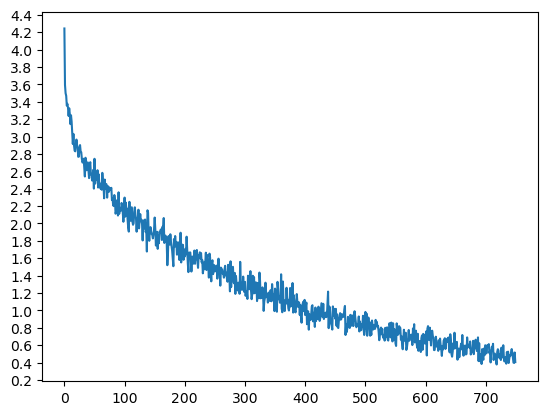

In [22]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, iters, print_every=print_i)

In [23]:
evaluateRandomly(encoder1, decoder1, 10)

> je suis consciencieux .
= i m thorough .
< i m punctual . <EOS>

> je suis plus petit que vous .
= i am shorter than you .
< i am shorter than you . <EOS>

> nous sommes etudiants .
= we re students .
< we re students . <EOS>

> je suis content que ca te rende heureuse .
= i m glad that makes you happy .
< i m glad that makes you happy . <EOS>

> je suis voyante .
= i m psychic .
< i m psychic . <EOS>

> vous etes ma princesse .
= you re my princess .
< you re my partner . <EOS>

> il n est pas japonais .
= he is not japanese .
< he is not japanese . <EOS>

> il est assez vieux pour etre son pere .
= he s old enough to be her father .
< he s old enough to be father . <EOS>

> elles sont similaires .
= they re similar .
< they re similar . <EOS>

> il est loin d etre parfait .
= he is far from perfect .
< he is far from satisfied . <EOS>



In [24]:
# Sample sentences from original code translated using google translate

# she is five years younger than me.
evaluateAndShowAttention("elle a cinq ans de moins que moi .", encoder1, decoder1)

# she is too small.
evaluateAndShowAttention("elle est trop petit .", encoder1, decoder1)

# I am not afraid of dying.
evaluateAndShowAttention("je ne crains pas de mourir .", encoder1, decoder1)

# He is a talented young director.
evaluateAndShowAttention("c est un jeune directeur plein de talent .", encoder1, decoder1)

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>
input = elle est trop petit .
output = she s too slow . <EOS>
input = je ne crains pas de mourir .
output = i m not dying to die . <EOS>
input = c est un jeune directeur plein de talent .
output = he s a talented young . . <EOS>


#### AttnDecoderRNN using GRU

Run Time: 4m 6s (- 57m 32s) Epoch: (5000 6%) Loss Avg: 2.8943
Run Time: 7m 43s (- 50m 14s) Epoch: (10000 13%) Loss Avg: 2.2724
Run Time: 11m 32s (- 46m 9s) Epoch: (15000 20%) Loss Avg: 1.9822
Run Time: 15m 30s (- 42m 38s) Epoch: (20000 26%) Loss Avg: 1.7366
Run Time: 19m 49s (- 39m 38s) Epoch: (25000 33%) Loss Avg: 1.5352
Run Time: 24m 8s (- 36m 12s) Epoch: (30000 40%) Loss Avg: 1.3472
Run Time: 28m 9s (- 32m 10s) Epoch: (35000 46%) Loss Avg: 1.1785
Run Time: 32m 11s (- 28m 10s) Epoch: (40000 53%) Loss Avg: 1.0957
Run Time: 36m 7s (- 24m 4s) Epoch: (45000 60%) Loss Avg: 0.9896
Run Time: 40m 15s (- 20m 7s) Epoch: (50000 66%) Loss Avg: 0.8982
Run Time: 44m 16s (- 16m 5s) Epoch: (55000 73%) Loss Avg: 0.7787
Run Time: 48m 25s (- 12m 6s) Epoch: (60000 80%) Loss Avg: 0.6974
Run Time: 52m 34s (- 8m 5s) Epoch: (65000 86%) Loss Avg: 0.6605
Run Time: 56m 26s (- 4m 1s) Epoch: (70000 93%) Loss Avg: 0.5849
Run Time: 60m 22s (- 0m 0s) Epoch: (75000 100%) Loss Avg: 0.5199


<Figure size 640x480 with 0 Axes>

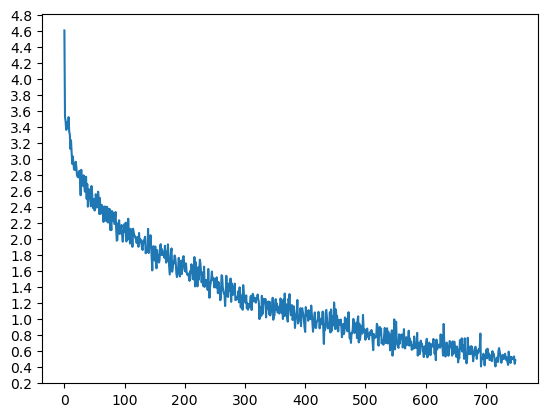

In [25]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder2, attn_decoder1, iters, print_every=print_i)


In [26]:
evaluateRandomly(encoder2, attn_decoder1, 10)

> c est un nouveau venu .
= he s a newcomer .
< he s a newcomer . <EOS>

> je suis sure que tom va le faire .
= i m sure that tom will do that .
< i m sure tom to do that . <EOS>

> je ne suis pas tout a fait surpris .
= i m not exactly surprised .
< i m not all surprised . <EOS>

> elle est tres occupee .
= she is as busy as a bee .
< she is very busy . . <EOS>

> elle s en sort tres bien .
= she s getting on all right .
< she s all to all right . <EOS>

> je suis si heureux pour vous tom .
= i m so happy for you tom .
< i m so happy to you tom . <EOS>

> il est en train de te regarder .
= he s looking at you .
< he s looking for you . <EOS>

> je ne fais pas le moindre projet .
= i m not making any plans .
< i m not making any plans . <EOS>

> c est ici qu il joue .
= he is playing here .
< he is playing here . . <EOS>

> je ne suis pas idiot .
= i m not a fool .
< i m not a fool . <EOS>



input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


/tmp/ipykernel_319/3538756434.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_319/3538756434.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


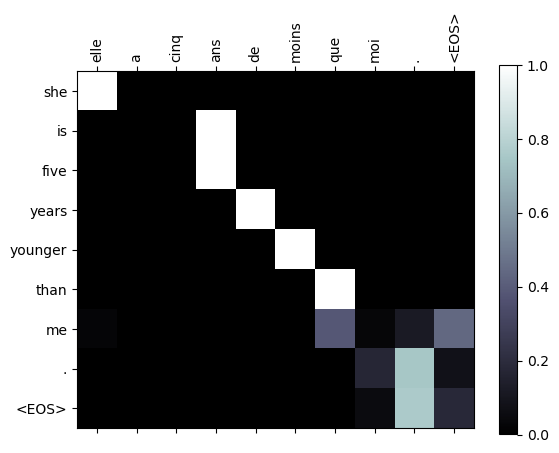

input = elle est trop petit .
output = she is too short . <EOS>


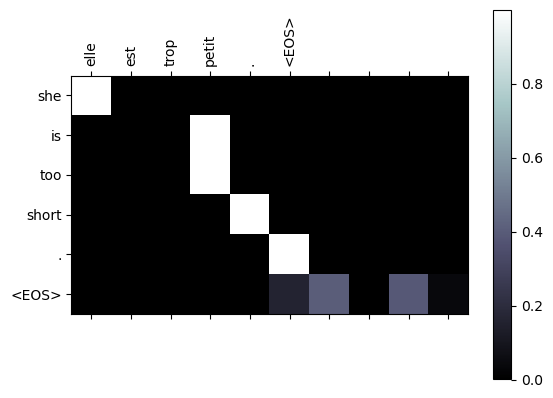

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


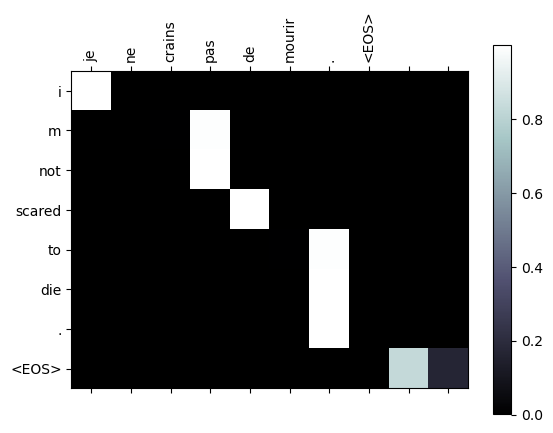

input = c est un jeune directeur plein de talent .
output = he s a talented young young . <EOS>


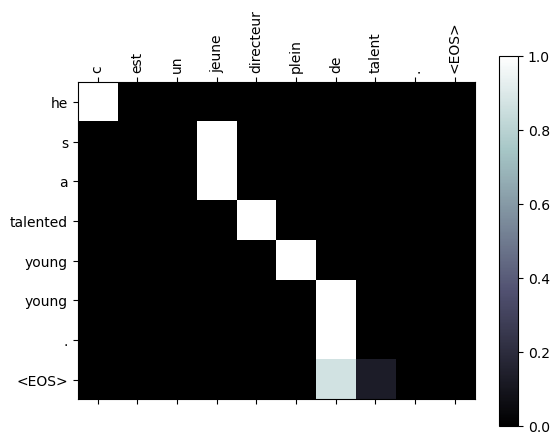

In [27]:
# Sample sentences from original code translated using google translate

# she is five years younger than me.
evaluateAndShowAttention("elle a cinq ans de moins que moi .", encoder2, attn_decoder1)

# she is too small.
evaluateAndShowAttention("elle est trop petit .", encoder2, attn_decoder1)

# I am not afraid of dying.
evaluateAndShowAttention("je ne crains pas de mourir .", encoder2, attn_decoder1)

# He is a talented young director.
evaluateAndShowAttention("c est un jeune directeur plein de talent .", encoder2, attn_decoder1)

#### AttnDecoderRNNLSTM using LSTM

Run Time: 4m 9s (- 58m 6s) Epoch: (5000 6%) Loss Avg: 3.0603
Run Time: 8m 14s (- 53m 37s) Epoch: (10000 13%) Loss Avg: 2.4897
Run Time: 12m 32s (- 50m 11s) Epoch: (15000 20%) Loss Avg: 2.1888
Run Time: 16m 48s (- 46m 13s) Epoch: (20000 26%) Loss Avg: 1.9867
Run Time: 21m 12s (- 42m 24s) Epoch: (25000 33%) Loss Avg: 1.8127
Run Time: 24m 54s (- 37m 21s) Epoch: (30000 40%) Loss Avg: 1.7269
Run Time: 28m 55s (- 33m 3s) Epoch: (35000 46%) Loss Avg: 1.5539
Run Time: 33m 17s (- 29m 8s) Epoch: (40000 53%) Loss Avg: 1.4117
Run Time: 37m 15s (- 24m 50s) Epoch: (45000 60%) Loss Avg: 1.3270
Run Time: 41m 17s (- 20m 38s) Epoch: (50000 66%) Loss Avg: 1.1946
Run Time: 45m 40s (- 16m 36s) Epoch: (55000 73%) Loss Avg: 1.1198
Run Time: 49m 50s (- 12m 27s) Epoch: (60000 80%) Loss Avg: 1.0369
Run Time: 53m 45s (- 8m 16s) Epoch: (65000 86%) Loss Avg: 0.9417
Run Time: 58m 6s (- 4m 9s) Epoch: (70000 93%) Loss Avg: 0.8759
Run Time: 62m 7s (- 0m 0s) Epoch: (75000 100%) Loss Avg: 0.8112


<Figure size 640x480 with 0 Axes>

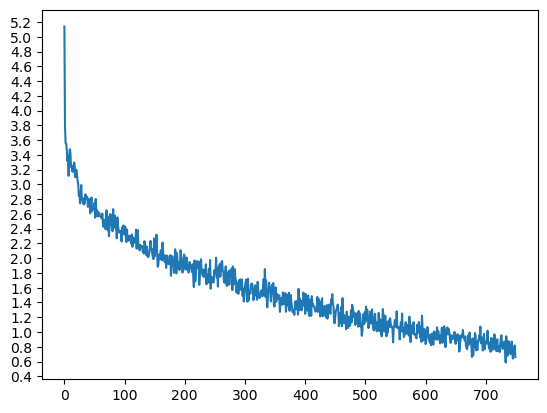

In [28]:
hidden_size = 256
cell_size = 256
encoder3 = EncoderRNNLSTM(input_lang.n_words, hidden_size, cell_size).to(device)
attn_decoder2 = AttnDecoderRNNLSTM(hidden_size, cell_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder3, attn_decoder2, iters, print_every=print_i)

In [29]:
evaluateRandomly(encoder3, attn_decoder2, 10)

> elle a tres peur du noir .
= she is very afraid of the dark .
< she is very afraid of the . . <EOS>

> nous sommes attaquees .
= we re under attack .
< we re being . <EOS>

> je suis aussi agee que toi .
= i m as old as you .
< i m as old as you . <EOS>

> je viens te chercher .
= i m coming to pick you up .
< i m coming to you up . <EOS>

> vous n etes pas tres amusantes .
= you re not very funny .
< you re not very tidy . <EOS>

> nous nous dirigeons vers l est .
= we re going east .
< we re going . . <EOS>

> c est un homme jaloux .
= he is a jealous man .
< he is a man man . <EOS>

> ils sont faibles .
= they re weak .
< they re weak . <EOS>

> nous petit dejeunons .
= we are having breakfast .
< we re undressing . <EOS>

> c est mon professeur .
= he is my teacher .
< he s my teacher . <EOS>



input = elle a cinq ans de moins que moi .
output = she s five years younger than i am . <EOS>


/tmp/ipykernel_319/3538756434.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_319/3538756434.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


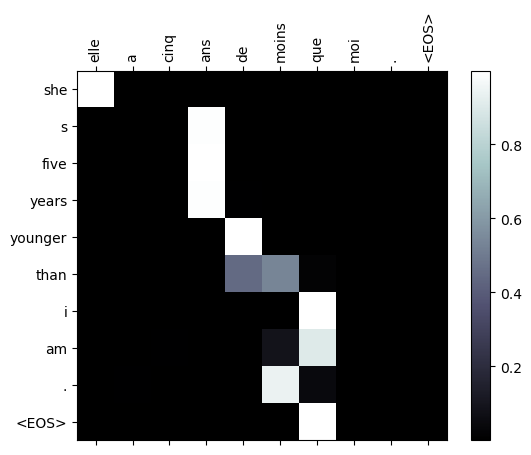

input = elle est trop petit .
output = she s too loud . <EOS>


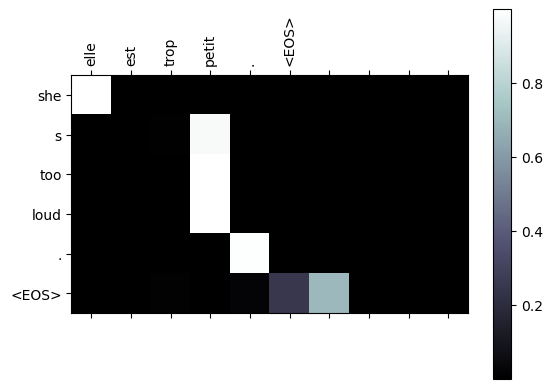

input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


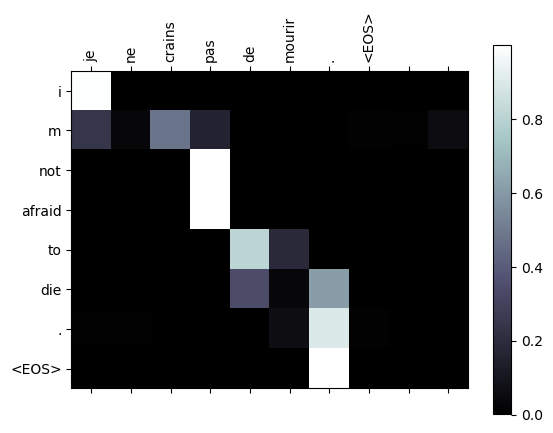

input = c est un jeune directeur plein de talent .
output = he s a talented of . . <EOS>


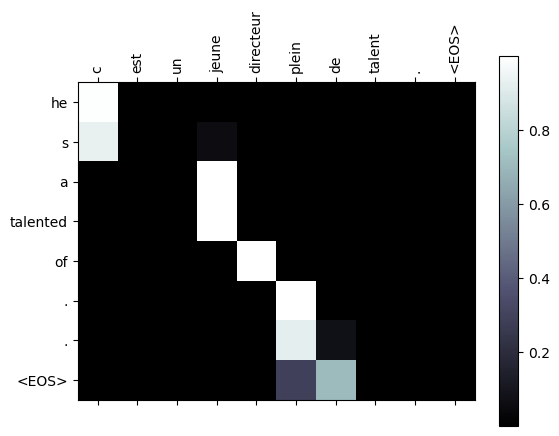

In [30]:
# Sample sentences from original code translated using google translate

# she is five years younger than me.
evaluateAndShowAttention("elle a cinq ans de moins que moi .", encoder3, attn_decoder2)

# she is too small.
evaluateAndShowAttention("elle est trop petit .", encoder3, attn_decoder2)

# I am not afraid of dying.
evaluateAndShowAttention("je ne crains pas de mourir .", encoder3, attn_decoder2)

# He is a talented young director.
evaluateAndShowAttention("c est un jeune directeur plein de talent .", encoder3, attn_decoder2)

### Summary Run

The execution summary below was used for the comparisons as the Run Time, Loss and Translation always varies.

#### DecoderRNN
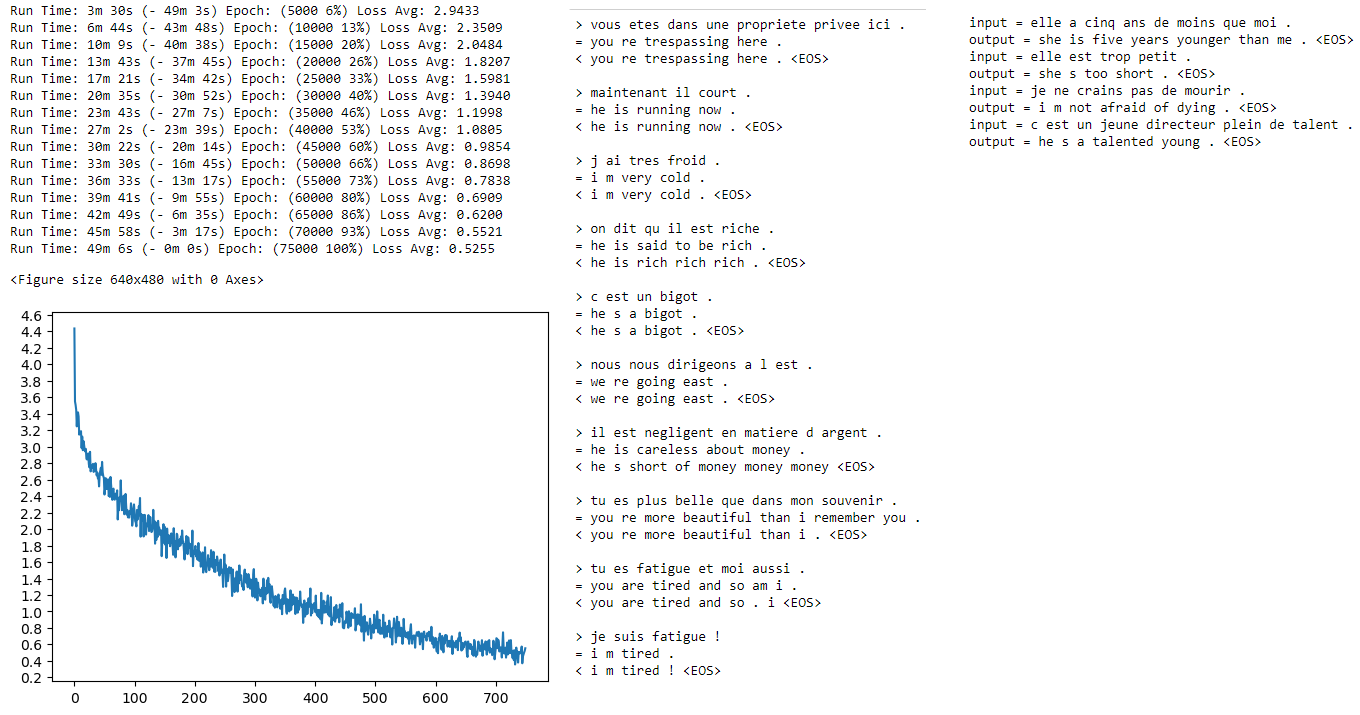

#### AttnDecoderRNN 
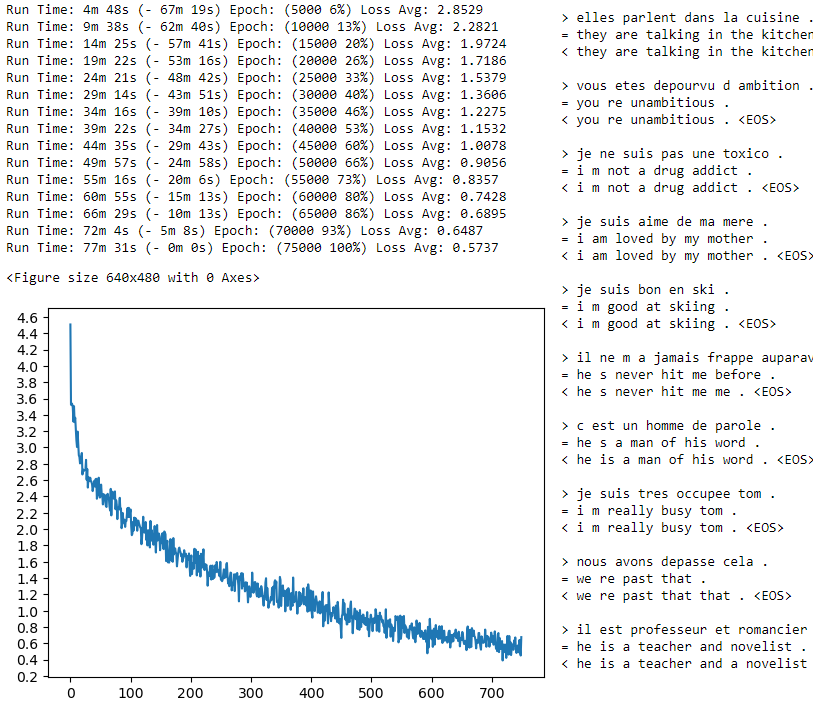

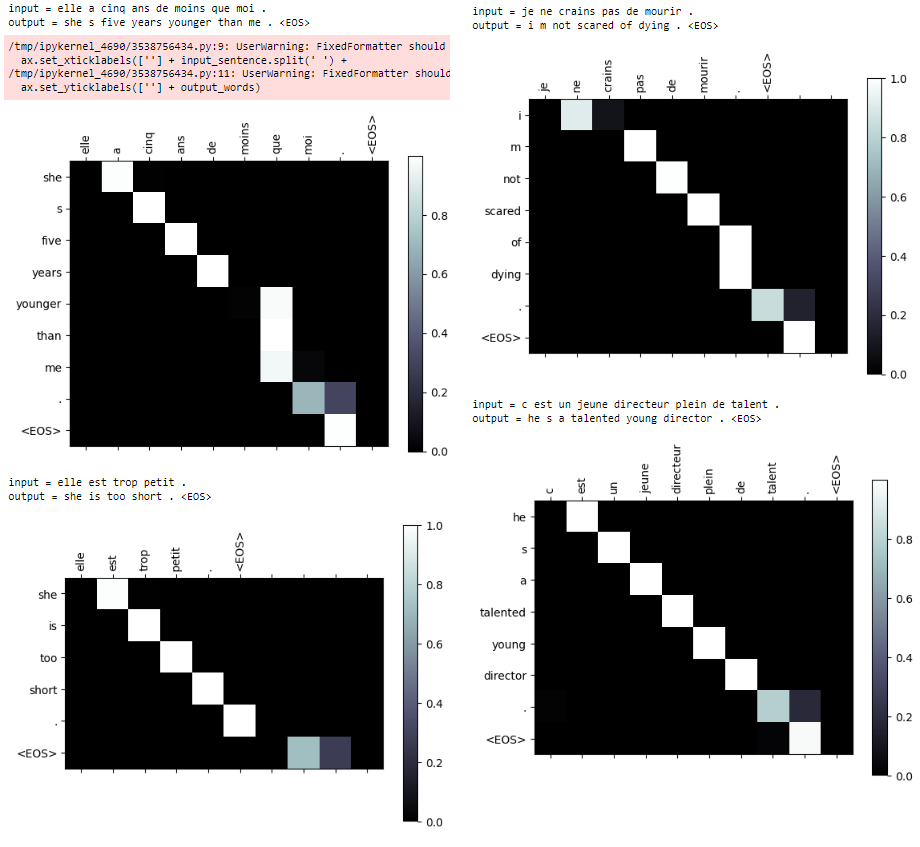

#### AttnDecoderRNNLSTM 
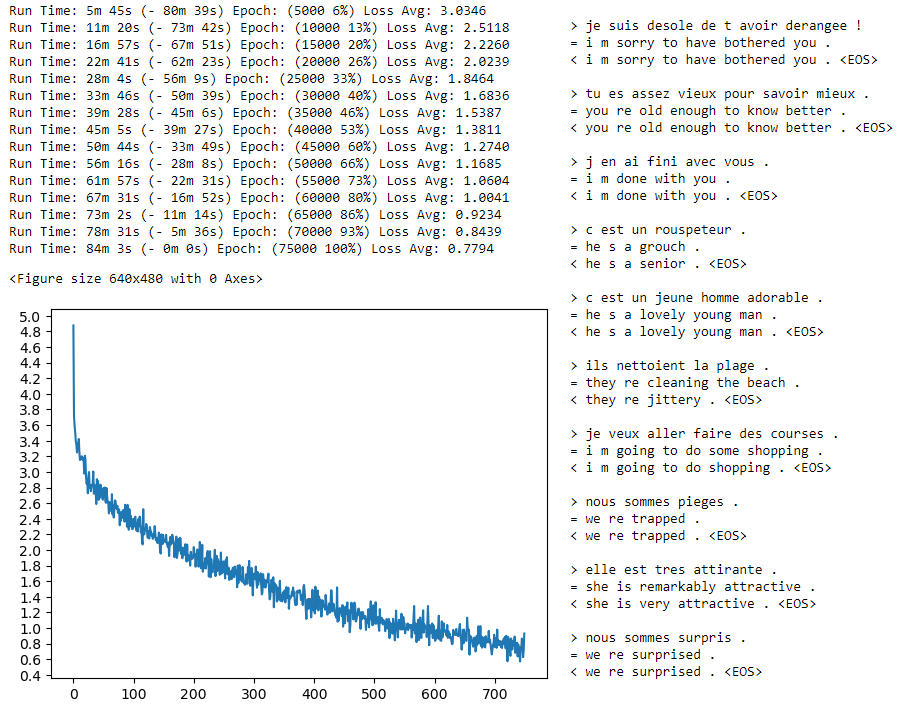

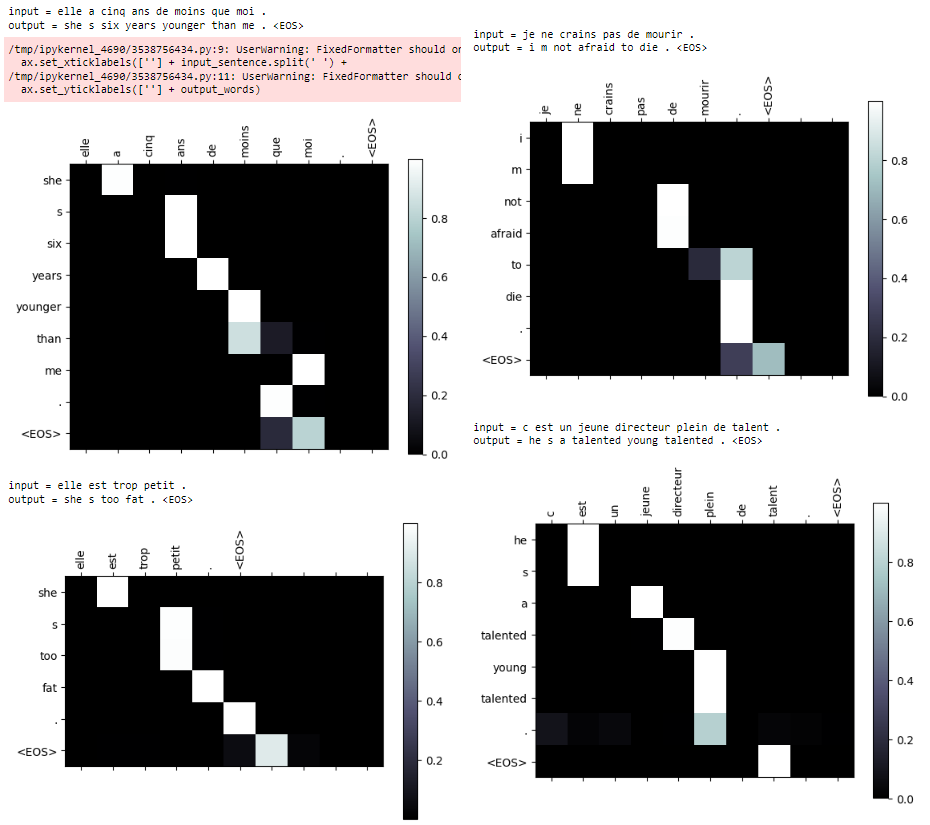

### Parameter Counts

In [44]:
def count_param(model):
    return sum(p.numel() for p in model.parameters())
    
print("Total parameters Encoder (GRU) (EncoderRNN - DecoderRNN): ", count_param(encoder1))
print("Total parameters Decoder (GRU) (EncoderRNN - DecoderRNN): ", count_param(decoder1))

print("Total parameters Encoder (GRU) (EncoderRNN - AttnDecoderRNN): ", count_param(encoder2))
print("Total parameters Decoder (GRU) (EncoderRNN - AttnDecoderRNN): ", count_param(attn_decoder1))

print("Total parameters Encoder (LSTM) (EncoderRNNLSTM - AttnDecoderRNNLSTM): ", count_param(encoder3))
print("Total parameters Decoder (LSTM) (EncoderRNNLSTM - AttnDecoderRNNLSTM): ", count_param(attn_decoder2))


Total parameters Encoder (GRU) (EncoderRNN - DecoderRNN):  1507072
Total parameters Decoder (GRU) (EncoderRNN - DecoderRNN):  1832691
Total parameters Encoder (GRU) (EncoderRNN - AttnDecoderRNN):  1507072
Total parameters Decoder (GRU) (EncoderRNN - AttnDecoderRNN):  1969149
Total parameters Encoder (LSTM) (EncoderRNNLSTM - AttnDecoderRNNLSTM):  1638656
Total parameters Decoder (LSTM) (EncoderRNNLSTM - AttnDecoderRNNLSTM):  2100733


## Compare and contrast the DecoderRNN and AttnDecoderRNN models in terms of loss, training time, parameter count, and quality of translation.

We've executed both models with total of `75,000` iterations and printed every `5000` with the loss being plotted at default at 100 eopchs. I've already run this multiple times and the results of the analysis are consistent though the exact values vary from run to run.

**Training Time**
       
       "DecoderRNN" is an architecture that runs faster due to its lower complexity. It doesn't have extra parameters to calculate and only runs through the RNN with the embedding. On the other hand, "AttnDecoderRNN" needs to calculate attention weights and apply them to the context vector at each time step. This additional calculation increases the runtime. Based on the observed runtime data, "AttnDecoderRNN" runs, on average, around 2-3 minutes longer per 5000 iterations, resulting in a total runtime increase of 60%~.
    
**Parameter Count**
        
       The encoder in both models has the same parameter count because they have the same inputs and overall architecture.

        The total number of parameters for the Encoder (GRU) in the EncoderRNN - DecoderRNN is 1,507,072
    While for the Encoder (GRU) in the EncoderRNN - AttnDecoderRNN, it is also 1,507,072.

        The DecoderRNN decoder has fewer parameters because it does not include attention parameters. On the other hand, the AttnDecoderRNN decoder includes attention parameters. Despite both decoders receiving the same inputs from the encoder, the inclusion of attention in AttnDecoderRNN increases the parameter count.

        The total number of parameters for the Decoder (GRU) in the EncoderRNN - DecoderRNN is 1,832,691
    While for the Decoder (GRU) in the EncoderRNN - AttnDecoderRNN, it is 1,969,149.

        It's important to note that the presence of attention does not always mean more parameters. The parameter count depends on factors such as input size, hidden size, and the number of layers in the models. In this case, since the same sizes were used, it was expected that the model utilizing attention would have more parameters.
        
        
**Training Loss**
        
        In this part, we expected the `AttnDecoderRNN` to have a lower training loss due to its ability to leverage more information. However, even after 75k iterations, the `DecoderRNN` exhibits a slightly lower loss of 0.05 (the range is usually .01 to .05). Based on readings intuition regarding this is that the sequence length of 10 might be too short to fully exploit the attention mechanism's benefits.The dataset samples were too simple and putting in attention only improved it marginally. Since not much information is lost even when the RNN decodes solely based on the hidden state, the attention feature might not be maximized. We also need to note that forced teaching may have affected the quality as it teaches it with the right predictions. The good thing for both the loss is consistently decreasing after a few hundred iterations.
        
**Quality of translation**
        
        The performance is nearly equal for both models, `AttnDecoderRNN` and `DecoderRNN`, as both were able to correctly capture the context for almost all sentences. The only inconsistent prediction occurred when the word "director" was used in the last sample of the code. This inconsistency might be due to the infrequent occurrence of the word "director" in the training pairs, leading to a lack of learning in that specific context. Additionally, when examining the translation problem, it becomes apparent that it typically arises towards the end of the sequence, even when considering the randomization of the training samples mentioned earlier. While both models consistently predict pronouns and verbs accurately, there are instances where the context for adjectives, adverbs, or the object being described is not precisely predicted. Nonetheless, the overall translation quality remains good after 75,000 iterations, considering the limitations inherent in paired translation.

    input = elle a cinq ans de moins que moi .
    actual = she is five years younger than me.
    output DecoderRNN = she is five years younger than me . <EOS>
    optput AttnDecoderRNN = she s five years younger than me . <EOS>
    
    input = elle est trop petit .
    actual = she is too small.
    output DecoderRNN = she s too short . <EOS>
    optput AttnDecoderRNN =  she is too short . <EOS>

    input = je ne crains pas de mourir .
    actual = I am not afraid of dying.
    output DecoderRNN = i m not afraid of dying . <EOS>
    optput AttnDecoderRNN = i m not scared of dying . <EOS>

    input = c est un jeune directeur plein de talent .
    actual = He is a talented young director.
    output DecoderRNN = he s a talented young . <EOS>
    output AttnDecoderRNN = he s a talented young director . <EOS>
        

## In the AttnDecoderRNN model, swap out the GRU for an LSTM. Compare and contrast the two models in terms of loss, training time, parameter count, and quality of translation.

We've executed both models with total of `75,000` iterations and printed every `5000` with the loss being plotted at default at 100 eopchs.  I've already run this multiple times and the results of the analysis are consistent though the exact values vary from run to run.

**Training Time**
        
        As discussed in class, the LSTM model was expected to be slower due to its complex architecture with more gates, requiring additional calculations. In the experiment, it was observed that the LSTM model takes longer to complete each epoch, with approximately 40 to 60 seconds more runtime every 5000 epochs. However, since the sequences used mostly consist of short sentences (max length of 10 tokens), the overall impact on runtime is relatively modest.
    
**Parameter Count**
        
        The encoder, specifically the EncoderRNN, has fewer parameters because it utilizes the GRU architecture, which has fewer gates compared to the LSTM used in the EncoderRNNLSTM.

        The total number of parameters for the EncoderRNN (GRU) in the AttnDecoderRNN is 1,507,072
        While for the EncoderRNNLSTM (LSTM) in the AttnDecoderRNNLSTM, it is 1,638,656.

        Both decoders employ attention mechanisms. However, similar to the encoder, the AttnDecoderRNN (GRU) has fewer parameters due to its usage of GRU with fewer gates, in contrast to the AttnDecoderRNNLSTM (LSTM) that employs LSTM.

        The total number of parameters for the Decoder (GRU) in the EncoderRNN - AttnDecoderRNN is 1,969,149
        While for the Decoder (LSTM) in the EncoderRNNLSTM - AttnDecoderRNNLSTM, it is 2,100,733.

        Similar behavior to our previous and based on the inputs, hidden sizes, and number of layers being the same, we can expect that LSTM would generally have more parameters than GRU, unless there are variations in the inputs. 
    
**Training Loss**
        
       From an architectural perspective, it was expected that `LSTM` would outperform `GRU`. However, in this case, the results show that the loss after 75k epochs is lower for `GRU` by around 0.2. Interestingly, `GRU` consistently performs better in my runs, although the average loss is sometimes close for both models. According to the literature, the simplicity of the dataset may have caused overfitting in `LSTM`. The dataset we are working with is relatively simple, comprising short-term dependencies with a maximum of 10 tokens per sentence, including punctuation marks (most sentences are around 6 tokens). In this context, the `GRU` architecture seems to exhibit better generalization, taking into account the characteristics of the dataset. On a positive note, for both models, the loss consistently decreases after a few hundred iterations.
        
**Quality of translation**
        
        Despite the difference in training loss, the quality of output for most translations is nearly the same for both `LSTM` and `GRU`, as evident from the random samples provided above. By considering only the samples below, it can be concluded that `GRU` performed better. However, in terms of context, both models were able to capture pronouns and some adjectives, although based solely on these samples, one might argue that the translations are subpar. It is important to note that certain words, such as "director," as mentioned earlier, may not have been adequately trained in this dataset.
        
    input = elle a cinq ans de moins que moi .
    actual = she is five years younger than me.
    optput GRU = she s five years younger than me . <EOS>
    optput LSTM = she s six years younger than me . <EOS>
    
    input = elle est trop petit .
    actual = she is too small.
    optput GRU =  she is too short . <EOS>
    output LSTM = she s too fat . <EOS>
    
    input = je ne crains pas de mourir .
    actual = I am not afraid of dying.
    optput GRU = i m not scared of dying . <EOS>
    output LSTM = i m not afraid to die . <EOS>
    
    input = c est un jeune directeur plein de talent .
    actual = He is a talented young director.
    output GRU = he s a talented young director . <EOS>
    output LSTM = he s a talented young talented . <EOS>

### Best Model AttnDecoder GRU 

We will be using the `AttnDecoder` with `GRU` for translation, as the regular `DecoderRNN` with  `GRU` does not have attention. Hence, we cannot analyze any plots, even though it performed better. We added a few more sentences and ensure the words are in the dictionary and checked the comparison of the output using Google Translate. Next, we will analyze each plot for the attention weights.

Google: she is five years younger than me.
input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


/tmp/ipykernel_4690/3538756434.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_4690/3538756434.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


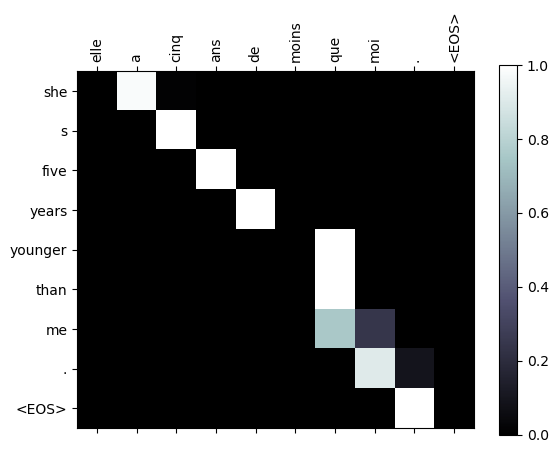


Google: she is too small.
input = elle est trop petit .
output = she is too short . <EOS>


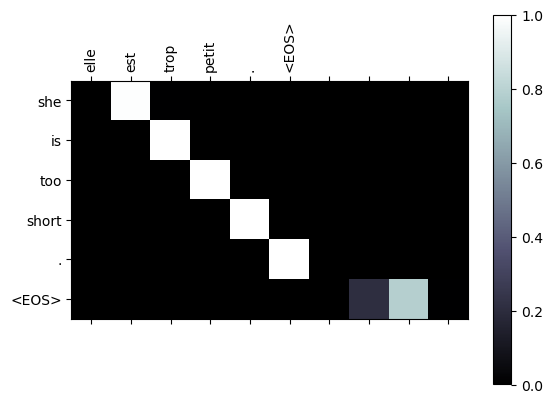


Google: I am not afraid of dying.
input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>


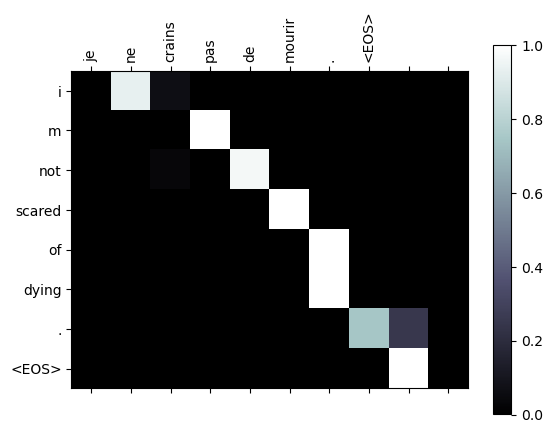


Google: He is a talented young director.
input = c est un jeune directeur plein de talent .
output = he s a talented young director . <EOS>


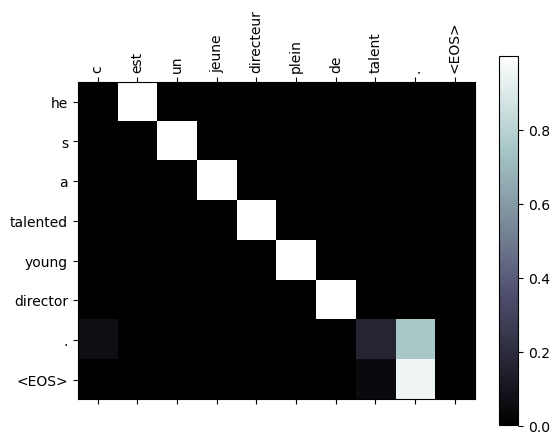


Google: she is ten years younger.
input = elle est dix ans plus jeune .
output = she is young years younger . <EOS>


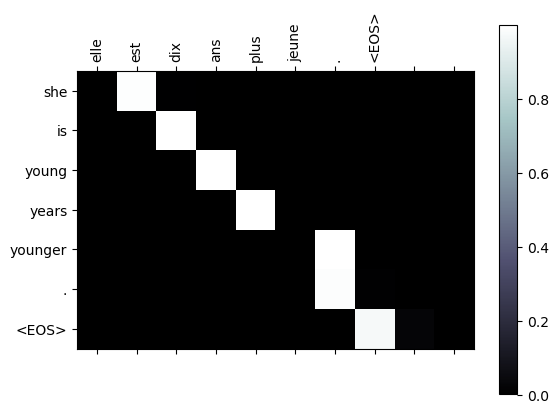


Google: You are intelligent .
input = vous etes intelligent .
output = you re clever . <EOS>


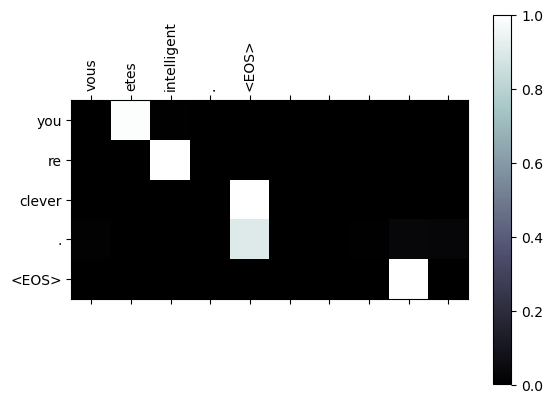


Google: they are sincerely happy and satisfied.
input = ils sont sincerement heureux et satisfaits .
output = they are disappointed and satisfied . <EOS>


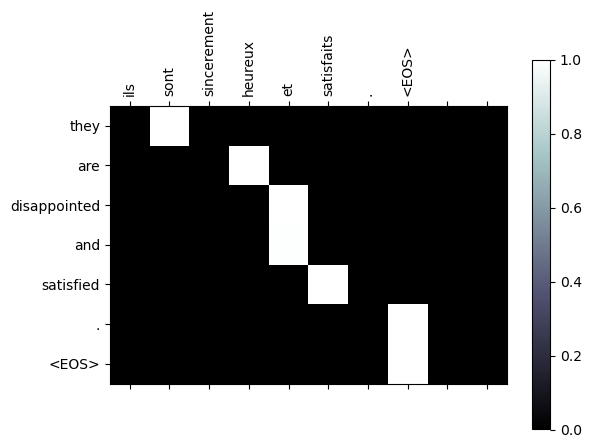


Google: she is incredibly kind.
input = elle est incroyablement bienveillante .
output = she s young to work . <EOS>


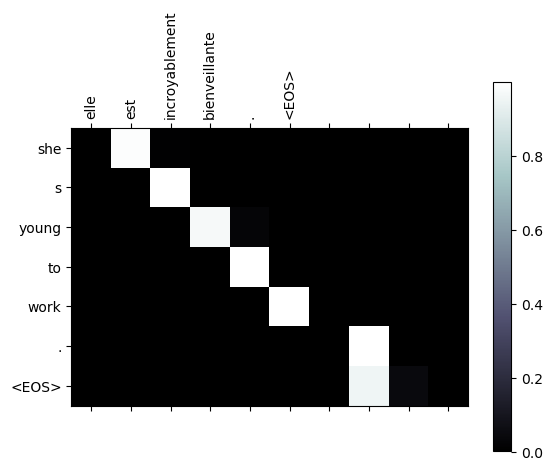

In [157]:
print('Google: she is five years younger than me.')
evaluateAndShowAttention("elle a cinq ans de moins que moi .", encoder2, attn_decoder1)
print()

print('Google: she is too small.')
evaluateAndShowAttention("elle est trop petit .", encoder2, attn_decoder1)
print()

print('Google: I am not afraid of dying.')
evaluateAndShowAttention("je ne crains pas de mourir .", encoder2, attn_decoder1)
print()

print('Google: He is a talented young director.')
evaluateAndShowAttention("c est un jeune directeur plein de talent .", encoder2, attn_decoder1)
print()

print('Google: she is ten years younger.')
evaluateAndShowAttention("elle est dix ans plus jeune .", encoder2, attn_decoder1)
print()

print('Google: You are intelligent .')
evaluateAndShowAttention("vous etes intelligent .", encoder2, attn_decoder1)
print()

print('Google: they are sincerely happy and satisfied.')
evaluateAndShowAttention("ils sont sincerement heureux et satisfaits .", encoder2, attn_decoder1)
print()

print('Google: she is incredibly kind.')
evaluateAndShowAttention("elle est incroyablement bienveillante .", encoder2, attn_decoder1)
print()


Out of the provided samples, only **5 out of 8** were accurately translated when compared to Google Translate. For the last four sentences, which had newly added words and rearranged placements, only **1 out of 4** was correct in terms of contextual meaning, but not in terms of direct translation. The translations that were not successful managed to capture approximately `50%` of the intended translation, but they failed to maintain effective context.

Upon analyzing the attention plots, it becomes evident that the pronoun at the beginning of the sentence receives a high attention score and is translated correctly. The attention plots also exhibit a clear diagonal pattern, indicating a well-trained model. In some instances, there is a shift in alignment as the model attempts to focus on the translation of specific inputs and tries to find a similar pattern for their translation.

This could potentially be a case of overfitting on short samples and the contextual usage of certain words within the sentence. Take, for example, the last sentence "She is incredibly kind." Despite its brevity, it was not translated accurately. It's possible that the word "incredibly" was used differently in our samples, resulting in the translation. We can see it that "young to work" was the translation used for kind and might have a combination describing someone as kind with a modifier adverb. 

This observation is particularly evident in the sentence "They are sincerely happy and satisfied." Despite the presence of the modifier "sincerely happy," the model's attention appears to have focused on "disappointed and satisfied." This may be due to the fact that the phrase "disappointed and" is commonly associated with "they are" rather than in conjuction with "happy". On the other hand, the word "sincerely" might not have been frequently used in a similar combination and this a complete opposite context being "dissapointed" and "satisfied". It may have been affected by having an adverb "sincerely" and may have been also used in combination with "dissapointed"

When attempting to remove the modifiers, it is observed that the attention remains focused on the second word onwards, and the model generates translations using highly scored phrases such as "they are satisfied" instead of capturing the intended meaning of "heureux" (happy). This suggests that the model may have learned to associate "satisfied" more strongly with "they are" and may not have effectively learned the translation for "happy" in certain contexts, despite examples being present in the training data.

Additionally, the word "bienveillante" indicates a good translation of "good-natured" when considering the context after removing the adverb.

In qualitative comparison to Google Translate, our model performs reasonably well, but there may be potential issues due to overfitting on the limited translations and word usage provided. It is possible that incorporating more varied adverbs could help improve the model's performance. However, for simple and shorter sentences, the model was able to generate accurate translations.

Google: they are happy and satisfied.
input = ils sont heureux et satisfaits .
output = they are satisfied and satisfied . <EOS>


/tmp/ipykernel_4690/3538756434.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_4690/3538756434.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


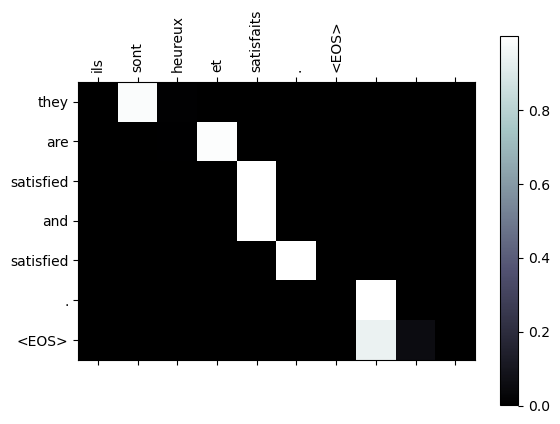


Google: she is kind.
input = elle est bienveillante .
output = she is good natured . <EOS>


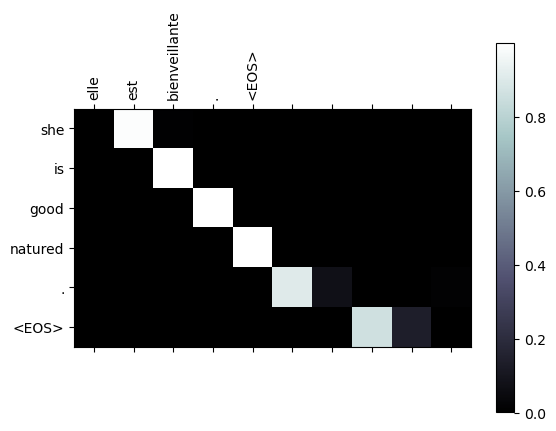

In [159]:
print('Google: they are happy and satisfied.')
evaluateAndShowAttention("ils sont heureux et satisfaits .", encoder2, attn_decoder1)
print()

print('Google: she is kind.')
evaluateAndShowAttention("elle est bienveillante .", encoder2, attn_decoder1)
print()


## Conclusion

Through this homework assignment, I have gained a clear understanding of how the architecture works for Neural Machine Translation (NMT), including the behavior of the Encoder and Decoder with and without Attention. Engaging in activities such as running, debugging, and editing the code has significantly enhanced my comprehension, making it one of the best ways to learn about deep learning in general.

The performance of the `GRU` surpassed that of the LSTM. Based on the loss, the `DecoderRNN` utilizing `GRU` performed on par with the `AttDecoderRNN` using `GRU` and outperformed the `AttDecoderRNNLSTM` with `LSTM` and other models. This could be attributed to our short samples, where having fewer tokens and a less complex model proved to be advantageous. `GRU` has fewer gates and is able to store short-term dependencies effectively. Conversely, `LSTM` may have suffered from overfitting due to the limited sample size, resulting in a higher loss. Additionally, `LSTMs` tend to excel in capturing long-term dependencies, as they have more gates to work with and tend to store and output different information compared to `GRU`.

Although the translations of the samples were satisfactory, utilizing the best model with attention, namely the `AttnDecoderRNN` with `GRU`, faced challenges in translating words not present in the provided samples. This suggests that the model struggled to generalize well and potentially suffered from overfitting. Analysis of the attention weight plots revealed that the focus was primarily on the initial set of words, while subsequent translations relied heavily on phrases from the samples.

Attention plots have proven to be valuable in evaluating translation quality and understanding the patterns by which the model learns to translate. I have observed that translations tend to suffer when encountering modifier adverbs, primarily due to the scarcity of samples written in a similar fashion. Consequently, translating longer sentences with intricate relationships necessitates a substantial amount of data, particularly in order to achieve satisfactory results.

In summary, we can still improve the model by having more data, try out longer sequence, tune the parameters and try out other optimizers to help with the learning. It is not always true that `GRU` will consistently outperform `LSTM` for shorter sequence data, and we always need to run tests and iterations to draw such conclusions. Then for me this assignment has served as an excellent learning exercise, allowing me to grasp the concepts of `RNN (GRU and LSTM)`, `Encoder-Decoder` models with and without attention. It has successfully achieved its goal of enhancing my understanding in this domain.

## Generative AI Documentation

This is how I used ChatGPT to assist me in the assignemnt:
    
- Asked to explain NMT in the context of Encoder-Decoder with RNN.
- Asked to explain step by step implementation of an Encoder-Decoder for RNN with and without attention.
- Helped me with adding comments in the code.
- Helped me fix all the sentences grammars and spell checks.
- Helped validate context of some of my writings and it was able to fix some that I interpreted incorrectly.
- I usually asked ChatGPT to write me a smaller version of a code I can sample on since its faster than me writing it even though I know what to code already.
- Assist with my analysis on all scenarios if the AI agrees then I do readings to just be confident about it.
- Asked to create some samples for the sentences then I refined it further to fit the dictionary we have.


## References 

1. Used to understand how Attention works in Encoder-Decoder for RNN

    Alammar, J. (n.d.). Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention). Jalammar.github.io. https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
    
    https://www.facebook.com/jason.brownlee.39. (2019, March 6). How Does Attention Work in Encoder-Decoder Recurrent Neural Networks. Machine Learning Mastery. https://machinelearningmastery.com/how-does-attention-work-in-encoder-decoder-recurrent-neural-networks/
    
    Chauhan, M. (2021, February 25). A Simple Overview of RNN, LSTM and Attention Mechanism. Medium. https://medium.com/swlh/a-simple-overview-of-rnn-lstm-and-attention-mechanism-9e844763d07b
    
    Attention in Neural Networks. (n.d.). Www.youtube.com. Retrieved May 14, 2023, from https://www.youtube.com/watch?v=W2rWgXJBZhU&t=305s&pp=ygUNYXR0ZW50aW9uIFJOTg%3D%3D
    
    Sequence To Sequence Learning With Neural Networks| Encoder And Decoder In-depth Intuition. (n.d.). Www.youtube.com. Retrieved May 14, 2023, from https://www.youtube.com/watch?v=jCrgzJlxTKg&pp=ygUNYXR0ZW50aW9uIFJOTg%3D%3D     
***
2. Pytoch Documentation to understand the parameters for GRU and LSTM

    torch.nn — PyTorch master documentation. (n.d.). Pytorch.org. https://pytorch.org/docs/stable/nn.html
***
3. Understanding GRU and LSTM further

    Lendave, V. (2021, August 28). LSTM Vs GRU in Recurrent Neural Network: A Comparative Study. Analytics India Magazine. https://analyticsindiamag.com/lstm-vs-gru-in-recurrent-neural-network-a-comparative-study/
    
    neural network - When to use GRU over LSTM? (n.d.). Data Science Stack Exchange. Retrieved May 14, 2023, from https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm#:~:text=GRU%20is%20better%20than%20LSTM
    
    Which One is Faster either GRU or LSTM. (n.d.). Stack Overflow. https://stackoverflow.com/questions/59932978/which-one-is-faster-either-gru-or-lstm

    Kaiser, Ł. (2015, November 25). Neural GPUs Learn Algorithms. arXiv.org. https://arxiv.org/abs/1511.08228